## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*'.

# 1. Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import lightgbm as lgb
import lightgbm as lgm
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [2]:
print(df.index.is_monotonic)

True


In [3]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


# 2. Анализ

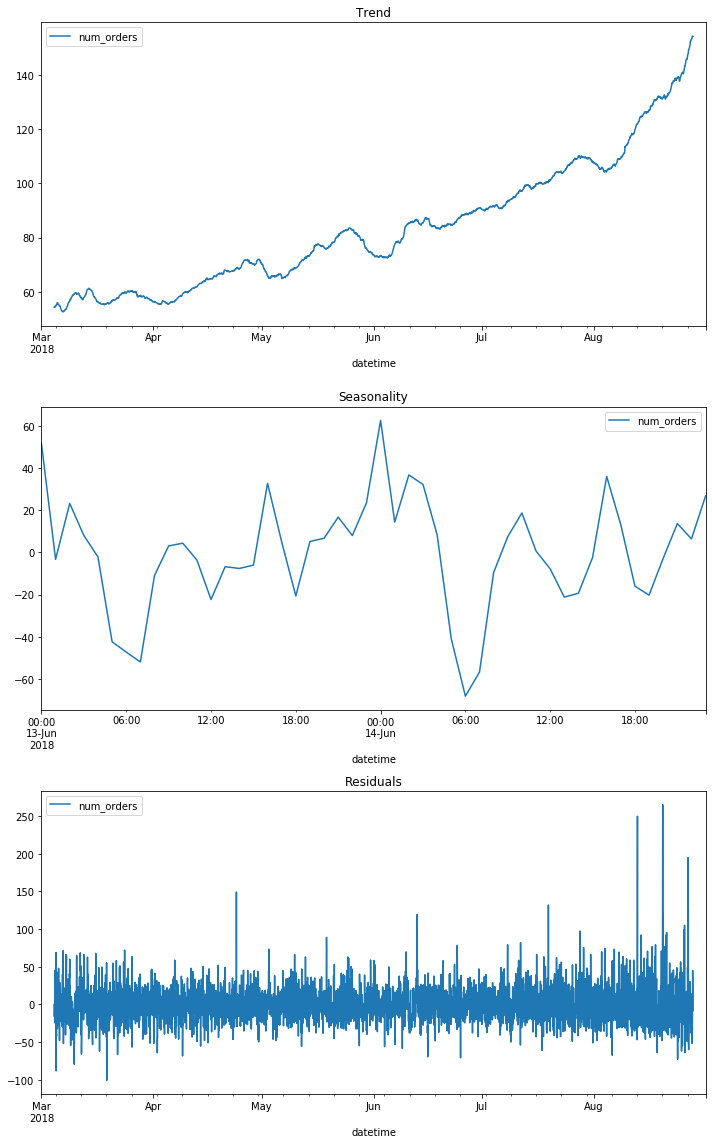

In [5]:
decompose = seasonal_decompose(df, freq=24*7)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-06-13':'2018-06-14'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

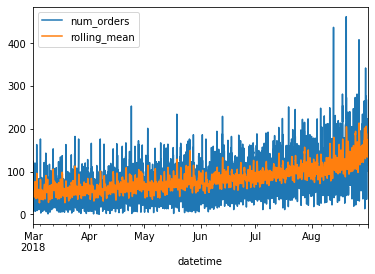

In [6]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot()

Из декомпозиции можно отметить, что тренд указывает на увеличение заказов. Сезоность указывает на высокий спрос на такси в ночное время, потому что в это время не работает общественный транспорт.

Можно сказать, что стохастический процесс нестационарный

# 3. Обучение

In [119]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 500, 300)
df.shape

(3057, 506)

In [120]:
df.head(10)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500
datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-26 15:00:00,59,NaN,2018,4,26,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26 16:00:00,115,NaN,2018,4,26,3,59.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26 17:00:00,59,NaN,2018,4,26,3,115.0,59.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26 18:00:00,57,NaN,2018,4,26,3,59.0,115.0,59.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26 19:00:00,46,NaN,2018,4,26,3,57.0,59.0,115.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26 20:00:00,63,NaN,2018,4,26,3,46.0,57.0,59.0,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26 21:00:00,89,NaN,2018,4,26,3,63.0,46.0,57.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26 22:00:00,104,NaN,2018,4,26,3,89.0,63.0,46.0,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26 23:00:00,118,NaN,2018,4,26,3,104.0,89.0,63.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
df = df.dropna()

In [122]:
df.shape

(2557, 506)

In [123]:
df.head(10)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500
datetime,,,,,,,,,,,,,,,,,,,,,
2018-05-17 11:00:00,92,69.913333,2018,5,17,3,92.0,91.0,61.0,27.0,...,121.0,118.0,104.0,89.0,63.0,46.0,57.0,59.0,115.0,59.0
2018-05-17 12:00:00,62,69.920000,2018,5,17,3,92.0,92.0,91.0,61.0,...,54.0,121.0,118.0,104.0,89.0,63.0,46.0,57.0,59.0,115.0
2018-05-17 13:00:00,63,69.780000,2018,5,17,3,62.0,92.0,92.0,91.0,...,73.0,54.0,121.0,118.0,104.0,89.0,63.0,46.0,57.0,59.0
2018-05-17 14:00:00,94,69.736667,2018,5,17,3,63.0,62.0,92.0,92.0,...,117.0,73.0,54.0,121.0,118.0,104.0,89.0,63.0,46.0,57.0
2018-05-17 15:00:00,71,69.800000,2018,5,17,3,94.0,63.0,62.0,92.0,...,59.0,117.0,73.0,54.0,121.0,118.0,104.0,89.0,63.0,46.0
2018-05-17 16:00:00,115,69.706667,2018,5,17,3,71.0,94.0,63.0,62.0,...,26.0,59.0,117.0,73.0,54.0,121.0,118.0,104.0,89.0,63.0
2018-05-17 17:00:00,79,69.990000,2018,5,17,3,115.0,71.0,94.0,63.0,...,6.0,26.0,59.0,117.0,73.0,54.0,121.0,118.0,104.0,89.0
2018-05-17 18:00:00,41,70.193333,2018,5,17,3,79.0,115.0,71.0,94.0,...,21.0,6.0,26.0,59.0,117.0,73.0,54.0,121.0,118.0,104.0
2018-05-17 19:00:00,73,70.266667,2018,5,17,3,41.0,79.0,115.0,71.0,...,62.0,21.0,6.0,26.0,59.0,117.0,73.0,54.0,121.0,118.0


Применим функцию make_features на подготовленный датасет. Разделим датасет (тестовая выборка 10%), попробуем разные модели:

In [124]:

train_val, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_val, shuffle=False, test_size=0.25)

train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']

valid_features = valid.drop('num_orders', axis =1)
valid_target = valid['num_orders']

test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

In [125]:
print(train.shape, valid.shape, test.shape)

(1725, 506) (576, 506) (256, 506)


Проведем подбор параметров на модели light gbm:

In [40]:
%%time
estim_new = lgb.LGBMRegressor(num_leaves= 31,learning_rate=0.01)


param_grid = {
    'n_estimators': [10,50,100,200],
    'max_depth': [10,15,30,40]
   
}

cv =KFold(random_state=1, n_splits=7)
gbm = GridSearchCV(estim_new, param_grid, cv=cv, scoring='neg_mean_squared_error')

gbm.fit(train_features, train_target)

print('Best parameters is:', gbm.best_params_)
print('Best score is:', gbm.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters is: {'max_depth': 15, 'n_estimators': 200}
Best score is: -434.1728700130335
CPU times: user 6min 56s, sys: 2.48 s, total: 6min 58s
Wall time: 7min 4s


In [126]:
light_gbm = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.01, max_depth=15, n_estimators=200)
light_gbm.fit(train_features, train_target)
pred4 = light_gbm.predict(valid_features)
rmse_light_gbm = mean_squared_error(valid_target, pred4)**0.5
rmse_light_gbm

35.6303090684481

И попробуем модель CatBoost:

In [115]:
%%time
model_cat = CatBoostRegressor(n_estimators = 200, loss_function = 'MAE', eval_metric = 'RMSE')
model_cat.fit(train_features, train_target, verbose=10)
predicted_valid2 = model_cat.predict(valid_features)
rmse_cat = (mean_squared_error(valid_target, predicted_valid2))**0.5
rmse_cat

0:	learn: 34.7336287	total: 39.5ms	remaining: 7.87s
10:	learn: 30.6262405	total: 1.72s	remaining: 29.6s
20:	learn: 27.7144751	total: 3.32s	remaining: 28.3s
30:	learn: 25.6662344	total: 4.91s	remaining: 26.8s
40:	learn: 24.2409156	total: 6.5s	remaining: 25.2s
50:	learn: 23.2703291	total: 8.09s	remaining: 23.6s
60:	learn: 22.4649788	total: 9.68s	remaining: 22.1s
70:	learn: 21.8787209	total: 11.3s	remaining: 20.5s
80:	learn: 21.3663013	total: 12.9s	remaining: 18.9s
90:	learn: 20.9338864	total: 14.5s	remaining: 17.3s
100:	learn: 20.6485021	total: 16s	remaining: 15.6s
110:	learn: 20.3148796	total: 17.5s	remaining: 14.1s
120:	learn: 20.0692509	total: 19.1s	remaining: 12.5s
130:	learn: 19.8514244	total: 20.7s	remaining: 10.9s
140:	learn: 19.6852914	total: 22.3s	remaining: 9.34s
150:	learn: 19.5010993	total: 23.8s	remaining: 7.73s
160:	learn: 19.3261189	total: 25.4s	remaining: 6.15s
170:	learn: 19.1750310	total: 27s	remaining: 4.58s
180:	learn: 18.9947769	total: 28.6s	remaining: 3s
190:	learn:

33.35865609173103

Лучшие параметры для light gbm max_depth=10, n_estimators=200. Применим их на модели.

In [127]:
test_features.shape, test_target.shape

((256, 505), (256,))

# 4. Тестирование

In [128]:

pred5 = light_gbm.predict(test_features)
rmse_light_gbm_test = mean_squared_error(test_target, pred5)**0.5
rmse_light_gbm_test

47.67885843026897

In [134]:

predicted_valid3 = model_cat.predict(test_features)
rmse_cat_test = mean_squared_error(test_target, predicted_valid3)**0.5
rmse_cat_test

57.40681386091541

Проверка модели на адекватность по среднему значению: 

In [129]:

predicted_mean = np.ones(test.shape[0])*train['num_orders'].mean()
rmse_mean = mean_squared_error(test_target, predicted_mean)**0.5
print("Оценка RMSE по среднему значению :", rmse_mean)

Оценка RMSE по среднему значению : 82.47300701391228


In [ ]:
Проверка модели на адекватность по последующему значению: 

In [130]:
predicted_previous = test['num_orders'].shift()
predicted_previous.shape

(256,)

In [131]:
predicted_previous.iloc[0] = test_target.iloc[-1]
rmse_previous = mean_squared_error(test_target, predicted_previous)**0.5
print("Оценка RMSE по послед. значению:", rmse_previous )

Оценка RMSE по послед. значению: 59.850595235135295


Сравним наше полученное значение rmse у модели lightGBM с мин. значением rmse при проверке моделей на среднем значении и на послед.значении( минимальное это rmse_previous со значением 58.9).

Если rmse на тествой выборке меньше, значит модель адекватна.

In [132]:
min_mean_prev = min(rmse_mean, rmse_previous)

In [133]:
if  min_mean_prev > rmse_light_gbm_test:
    print('адекватна')
else:
    print(('неадекватна'))

адекватна


В результате лучшая модель это CatBoost, значение метрики rmse на лучшей модели на тестовой выборке не превышает указанного в задании 48. 